## Import

In [1]:
import sklearn

## Cohen Coefficient

Commonly referred to as **Cohen's kappa (κ)**, is a statistical measure used to evaluate the level of agreement between two observers when both are classifying items into categorical variables. Unlike simple percentage agreement, Cohen's kappa takes into account the possibility of the agreement occurring by chance, providing a more robust estimate of inter-rater reliability. The (κ) coefficient is computed by:

\[
\kappa = \frac{P_o - P_e}{1 - P_e}
\]

Where:
- \( P_o \) is the **observed proportion of agreement** between the raters (i.e., the actual proportion of times the raters agree on their classification).
- \( P_e \) is the **expected proportion of agreement** by chance (i.e., the agreement that would be expected just due to random classification).

### Interpretation
Cohen’s kappa ranges from \(-1\) to \(1\):
- \( \kappa = 1 \): Perfect agreement.
- \( \kappa = 0 \): Agreement equivalent to chance.
- \( \kappa < 0 \): Agreement worse than chance, indicating systematic disagreement.

The interpretation of kappa values is subjective and can depend on the context, but a common guideline is:
- \( \kappa < 0 \): No agreement.
- \( 0.01 - 0.20 \): Slight agreement.
- \( 0.21 - 0.40 \): Fair agreement.
- \( 0.41 - 0.60 \): Moderate agreement.
- \( 0.61 - 0.80 \): Substantial agreement.
- \( 0.81 - 1.00 \): Almost perfect agreement.

**CONTROLLARE IL COMMENTO A QUESTA FORMULA, ho solo fatto un previsione sulla definizione dei parametri della funzione**


https://en.wikipedia.org/wiki/Effect_size
**IMP io ho preso la descrizione da [wikipedia](https://en.wikipedia.org/wiki/Cohen%27s_kappa#), ma non mi sembra la stessa formula implementata qui sotto**

In [2]:
import shap

/envs/ai4ni/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2, l1, L1L2
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.optimizers import SGD #stochastic gradient descent
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
from scipy import interp
import sklearn
import matplotlib.pyplot as plt

2024-10-28 10:05:22.443855: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 10:05:22.443919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 10:05:22.443957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 10:05:22.452015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Callback

In [4]:
early_stop = EarlyStopping(monitor='loss', patience=10)

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)


# COEHN COEFFICIENT 

In [5]:
def Cohen(g1, g2, f):
    n1 = len(g1)
    n2 = len(g2)
    N = n1 + n2
    Scores1 = g1[f].dropna()
    Scores2 = g2[f].dropna()
    var1 = Scores1.var()
    var2 = Scores2.var()
    mean1 = Scores1.mean()
    mean2 = Scores2.mean()
    sp = (((n1 - 1)*var1 + (n2 - 1)*var2) / (N - 2))**0.5
    d = (mean1 - mean2) / sp
    return d

# FunCtional features ROI name

In [6]:
path='data/'
df2 = pd.read_csv(path+'functional_features.csv')
df2 = df2.set_index('F')
df2

,ROI 1,ROI 2,r1,r2
F,,,,
0,101,102,Right Frontal Pole,Left Frontal Pole
1,101,2202,Right Frontal Pole,"Left Lateral Occipital Cortex, superior division"
2,102,2202,Left Frontal Pole,"Left Lateral Occipital Cortex, superior division"
3,101,2201,Right Frontal Pole,"Right Lateral Occipital Cortex, superior division"
4,102,2201,Left Frontal Pole,"Right Lateral Occipital Cortex, superior division"
...,...,...,...,...
5248,901,4702,"Right Superior Temporal Gyrus, anterior division",Left Supracalcarine Cortex
5249,4501,4702,Right Heschl's Gyrus (includes H1 and H2),Left Supracalcarine Cortex
5250,902,4702,"Left Superior Temporal Gyrus, anterior division",Left Supracalcarine Cortex


In [7]:
dict_f = pd.read_excel(path+'dict.xlsx')
dict_f

,Unnamed: 0,r1,r2
0,2933,R PostC,L SMA
1,731,R THA,R MTGto
2,1632,R MTGpost,L ANG
3,4543,R IFGtriang,R FOper
4,1611,R Tpole,L ANG
5,1866,R MTGpost,L MTGto
6,1855,R FOrb,L MTGto
7,3254,L Opole,L Subcallosal
8,3413,R SFG,L CUN
9,3295,L OFus,L Subcallosal


# Import dataframe and normalize with RobustScaler: DF_1

In [10]:
path='data/'

DFs = pd.read_csv(path+'Harmonized_structural_features.csv')
DFf = pd.read_csv(path+'Harmonized_functional_features.csv')

In [9]:
DFf

NameError: name 'DFf' is not defined

In [11]:
DFs = DFs.set_index('FILE_ID')
DFf = DFf.set_index('FILE_ID')
DFf= DFf.drop(['SITE', 'Database_Abide', 'AGE_AT_SCAN', 'DX_GROUP'], axis =1)
DF = DFs.join(DFf,how='inner')
DF = DF.reset_index()
DF.loc[DF.DX_GROUP == -1, 'DX_GROUP'] = 0

In [ ]:
DF

Text(0.5, 0, 'Sites')

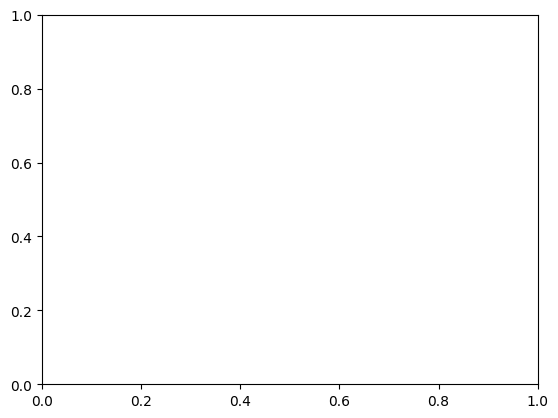

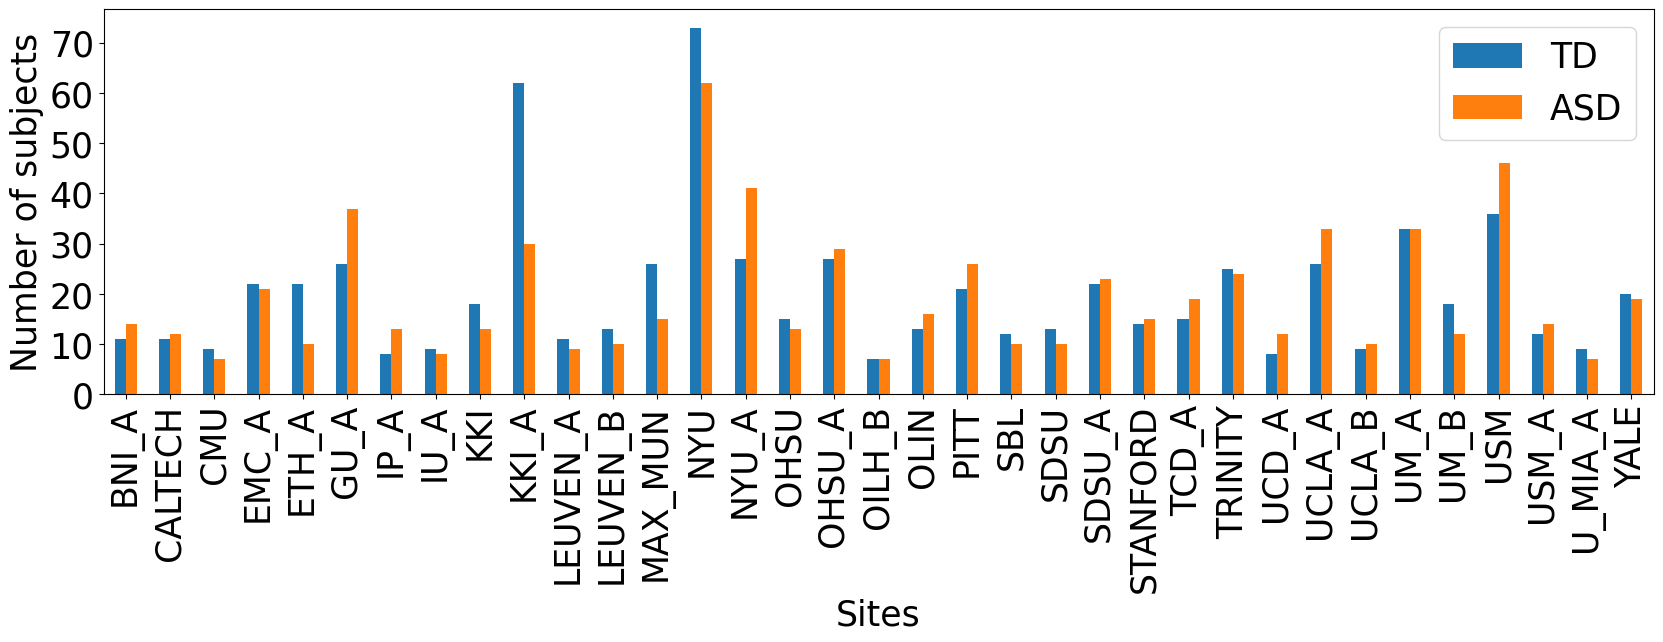

In [12]:
fig, ax = plt.subplots(1,1)

stack = DF.groupby(['SITE', 'DX_GROUP'])['SITE'].count()
unstacked = stack.unstack('DX_GROUP')
ax = unstacked.plot(kind='bar', stacked=False, fontsize = 25, figsize=(20,5)) #modifica stacked
ax.legend(["TD", "ASD"], fontsize=25);
plt.ylabel('Number of subjects', fontsize = 25)
plt.xlabel('Sites', fontsize = 25)

In [13]:
DF_1 = DF.drop(['SITE', 'Database_Abide', 'AGE_AT_SCAN', 'FILE_ID'], axis =1)
DF_1

,DX_GROUP,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalmiddlefrontal_GrayVol,lh_caudalmiddlefrontal_ThickAvg,lh_caudalmiddlefrontal_ThickStd,lh_cuneus_GrayVol,lh_cuneus_ThickAvg,lh_cuneus_ThickStd,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,1,4688.148643,2.930110,0.587509,8800.363280,2.325779,0.668543,3869.253795,1.951518,0.540253,...,-2.705760,-4.941687,-0.313784,-1.580897,-0.578138,0.800900,1.147299,-0.890745,4.318482,1.020236
1,1,3984.677523,2.882359,0.460643,6547.377947,2.435749,0.586677,3314.786185,2.122949,0.471802,...,-1.542383,-2.030129,0.686534,-3.049052,1.500650,-0.057321,-0.400296,0.395253,3.167437,-0.097813
2,1,4784.864858,2.737028,0.637104,9181.350601,2.683773,0.684515,4604.428639,2.103867,0.601115,...,3.010815,1.032087,-0.068159,-3.309840,-0.691436,-0.463286,-1.549897,0.358268,1.696029,-1.191784
3,1,2139.453979,2.286036,0.518532,6268.548302,2.528375,0.634880,3458.444707,1.957845,0.452045,...,2.469967,2.228592,-1.300355,1.016235,0.685534,-1.513635,0.778284,1.085581,-2.308573,-2.923374
4,1,6194.078262,2.955411,0.831313,11308.319412,2.380809,0.625219,4595.339126,2.124974,0.562617,...,1.399667,-1.951666,-1.588347,-0.684389,-1.423833,0.770992,-2.364999,3.107560,1.168626,-0.658174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,2760.894710,2.719528,0.645727,8044.910494,2.797142,0.640982,4603.816833,2.117092,0.538822,...,-2.494394,-2.287528,-2.692700,0.572010,-2.051990,-2.813308,-2.631377,-0.497931,5.814645,-1.464597
1379,0,3978.719928,2.766787,0.606700,7192.725506,2.764371,0.534917,5327.308393,2.102368,0.550826,...,-1.049086,-0.655575,2.143340,-4.697099,-0.670624,0.330856,-0.364826,2.593785,3.250819,1.271162
1380,0,2954.162825,2.897091,0.770469,8104.601082,2.905285,0.594737,5416.908509,2.291841,0.581176,...,0.638060,3.033216,-0.703276,0.765123,-0.741325,-0.049255,1.498713,-0.294101,9.475724,-0.006066
1381,0,3276.342103,2.925723,0.678409,7901.169064,2.882859,0.576567,5325.562172,2.209474,0.475749,...,-2.245569,1.083005,-0.479682,-0.084593,2.388419,-1.887193,2.116627,-2.294673,5.933953,0.806741


normalize all data with robustscaler


In [14]:
#normalize data
sc = RobustScaler()
DF_1.iloc[:,1:] = sc.fit_transform(DF_1.iloc[:,1:].to_numpy())
DF_1

,DX_GROUP,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalmiddlefrontal_GrayVol,lh_caudalmiddlefrontal_ThickAvg,lh_caudalmiddlefrontal_ThickStd,lh_cuneus_GrayVol,lh_cuneus_ThickAvg,lh_cuneus_ThickStd,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,1,1.268638,0.377530,-0.589783,0.326769,-1.746200,0.977805,-0.930078,-0.735032,0.054484,...,-0.557912,-1.667843,0.046921,-0.449884,-0.203291,0.482292,0.457513,-0.164615,-0.233920,0.474908
1,1,0.435023,0.195201,-1.497886,-0.869530,-1.260341,0.149260,-1.395270,-0.014497,-0.708084,...,-0.146633,-0.584021,0.436218,-0.952848,0.509680,0.173098,-0.099725,0.295015,-0.521565,0.056147
2,1,1.383247,-0.359718,-0.234784,0.529067,-0.164543,1.139456,-0.313275,-0.094698,0.732500,...,1.463021,0.555883,0.142512,-1.042189,-0.242149,0.026839,-0.513657,0.281796,-0.889267,-0.353597
3,1,-1.751570,-2.081748,-1.083519,-1.017585,-0.851110,0.637108,-1.274742,-0.708439,-0.928185,...,1.271820,1.001280,-0.337026,0.439847,0.230116,-0.351573,0.324643,0.541746,-1.890011,-1.002159
4,1,3.053168,0.474139,1.155356,1.658454,-1.503074,0.539329,-0.320901,-0.005986,0.303621,...,0.893446,-0.554813,-0.449105,-0.142757,-0.493343,0.471517,-0.807148,1.264425,-1.021064,-0.153735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,-1.015162,-0.426538,-0.173057,-0.074364,0.336335,0.698862,-0.313788,-0.039112,0.038536,...,-0.483189,-0.679837,-0.878889,0.287663,-0.708784,-0.819811,-0.903062,-0.024219,0.139968,-0.455778
1379,0,0.427964,-0.246087,-0.452409,-0.526861,0.191545,-0.374590,0.293213,-0.100998,0.172274,...,0.027758,-0.072346,1.003167,-1.517439,-0.235011,0.312947,-0.086953,1.080796,-0.500728,0.568892
1380,0,-0.786139,0.251453,0.719843,-0.042670,0.814119,0.230835,0.368386,0.695370,0.510382,...,0.624201,1.300800,-0.104659,0.353820,-0.259260,0.176004,0.584045,0.048632,1.054866,0.090510
1381,0,-0.404356,0.360779,0.060875,-0.150689,0.715041,0.046943,0.291748,0.349174,-0.664107,...,-0.395224,0.574837,-0.017642,0.062723,0.814161,-0.486156,0.806535,-0.666395,0.169783,0.394945


## Classificazione asd vs. td: solo features strutturali


In [15]:
def strutturale():
  input_data= Input(221,)
  x = Dense(32,  'relu', kernel_initializer='normal', kernel_regularizer=l1(0.01))(input_data)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x) #glorot_normal
  x = BatchNormalization()(x)
  #x = Dropout(0.1)(x) #-------------- cambiato risultasti stampati 0.2 --------------------
  x = Dense(1, 'sigmoid', kernel_regularizer=l1(0.01))(x)
  x = tf.keras.Model(inputs=input_data, outputs=x)
  return x


######### 13


2024-10-28 10:05:53.706438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-28 10:05:53.716235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-28 10:05:53.717790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<Figure size 640x480 with 0 Axes>

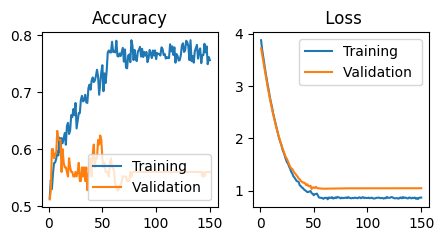

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


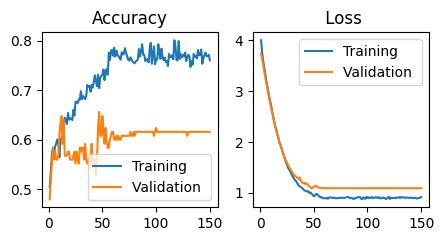

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


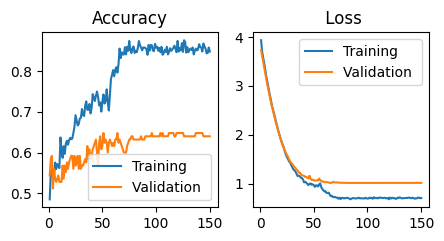

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


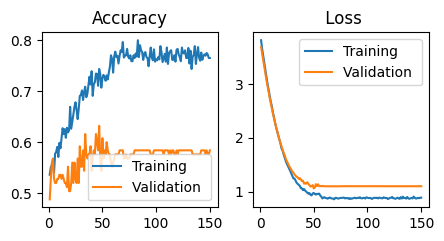

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


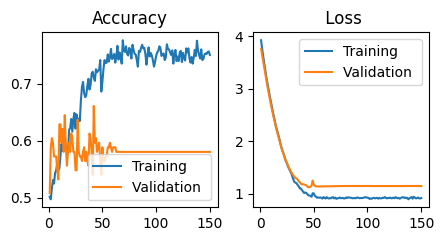

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


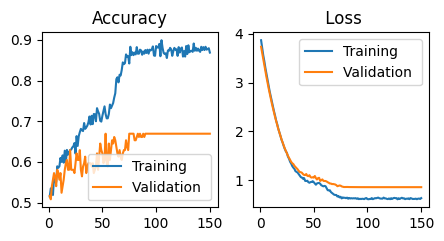

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


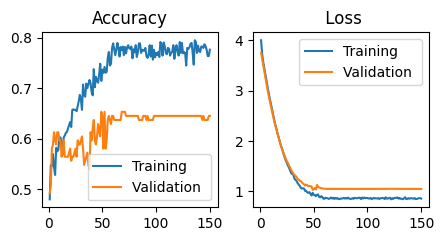

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


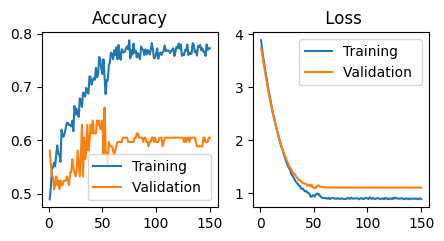

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


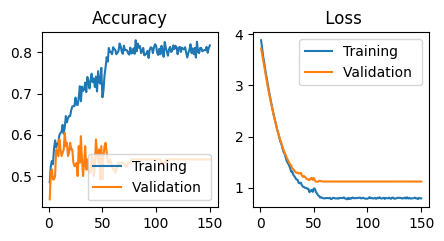

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


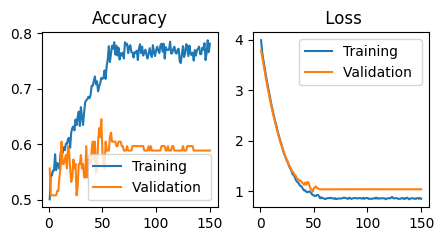

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


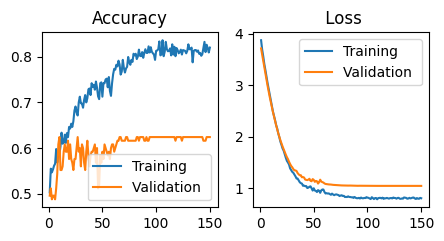

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


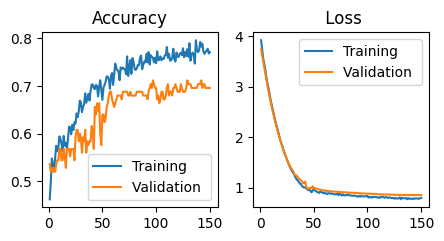

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


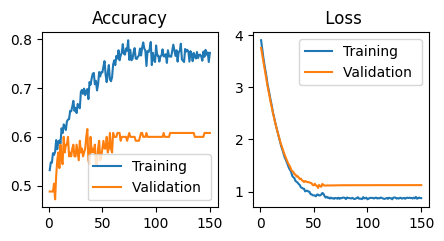

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


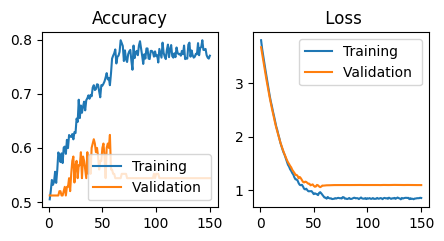

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


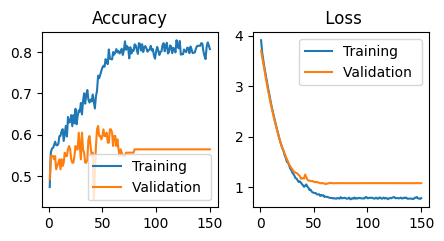

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


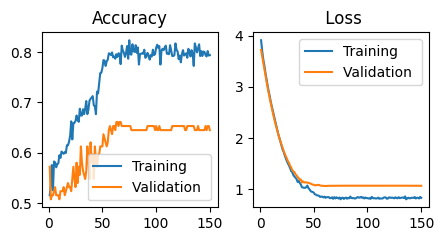

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


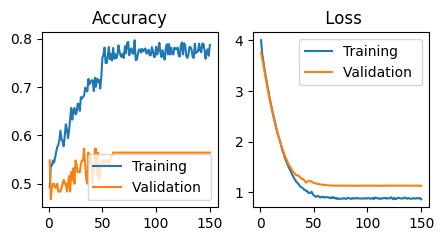

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 3ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


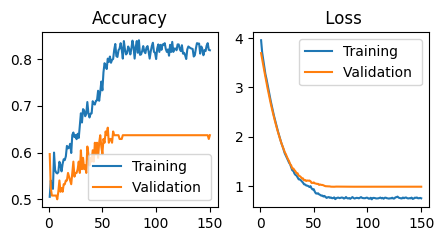

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


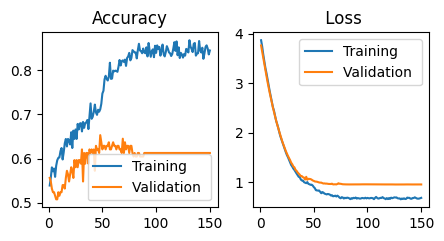

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


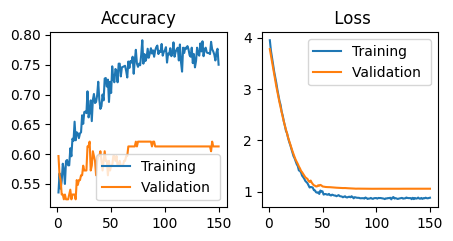

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


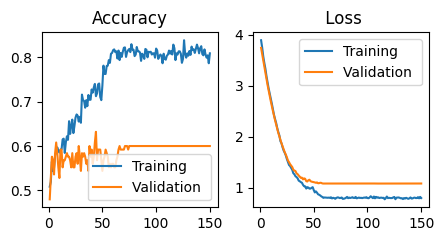

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


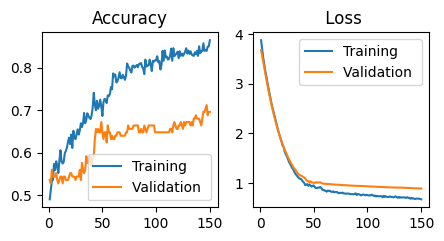

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


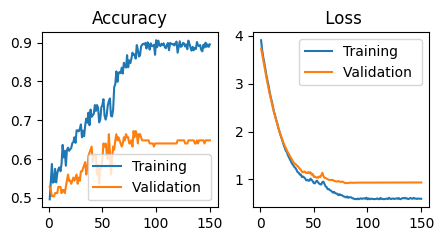

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


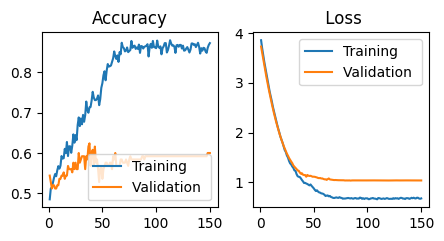

1119
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


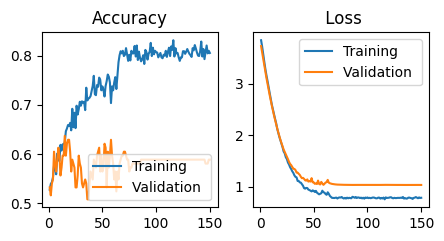

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


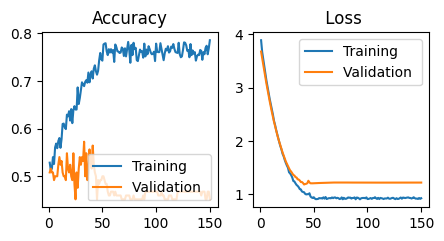

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


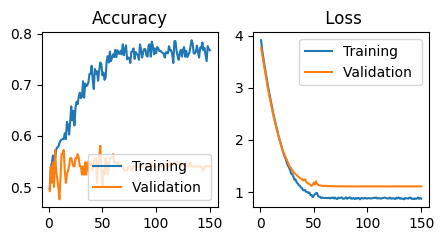

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


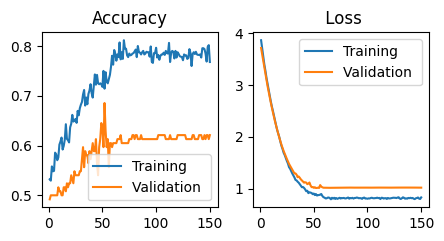

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


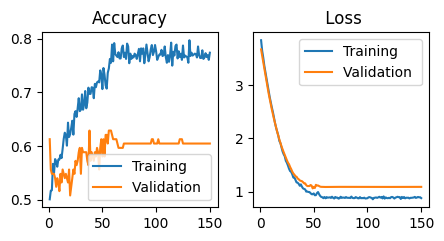

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


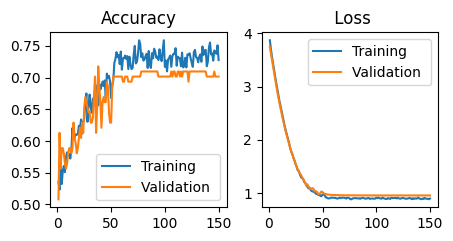

1120
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


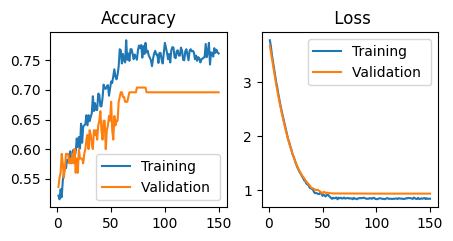

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


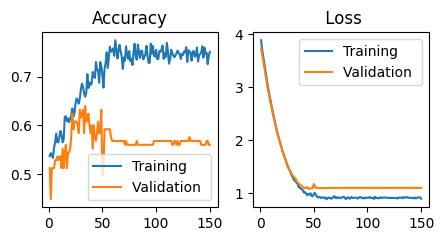

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


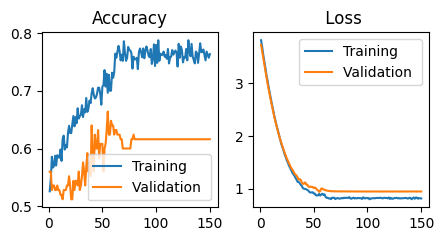

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


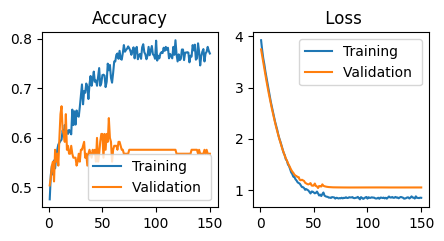

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


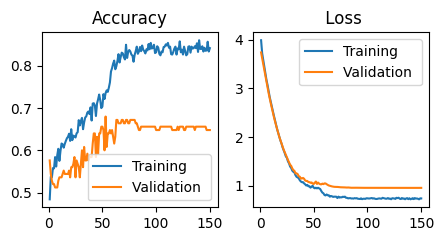

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


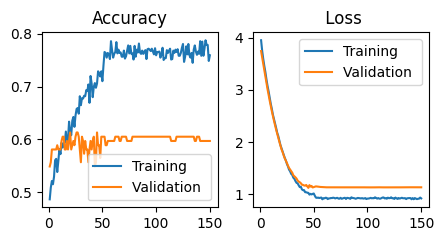

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


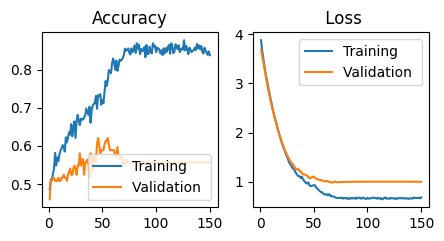

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


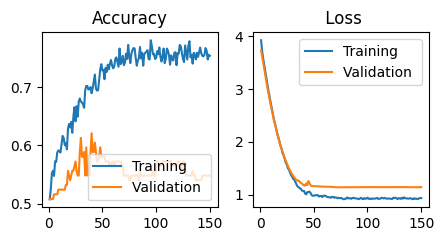

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


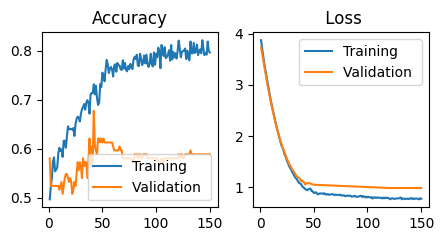

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


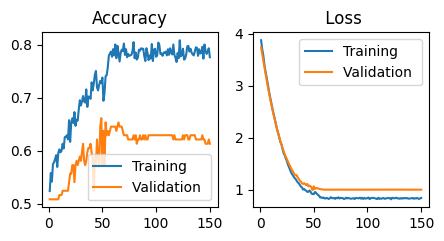

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 4ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


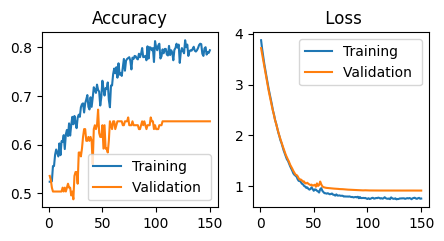

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


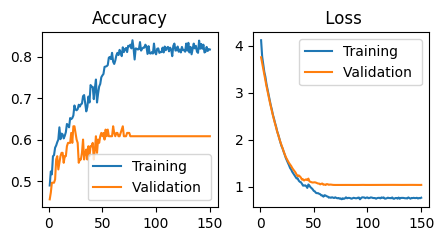

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


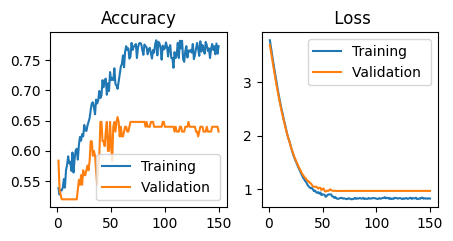

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


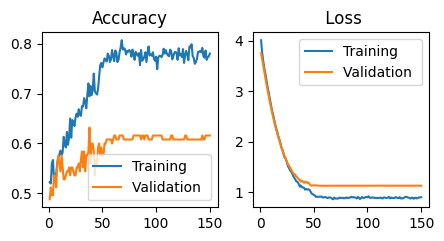

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


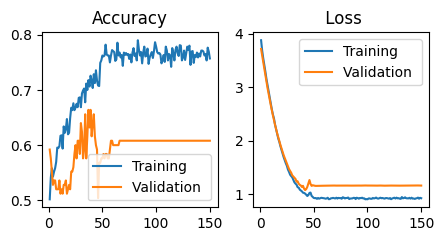

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


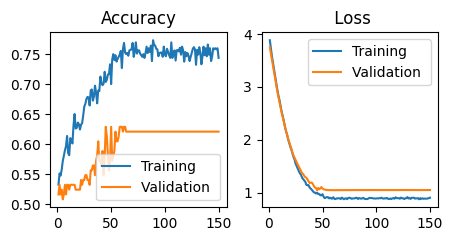

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 3ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


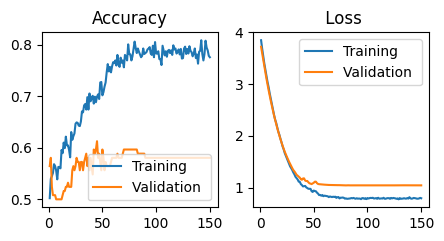

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


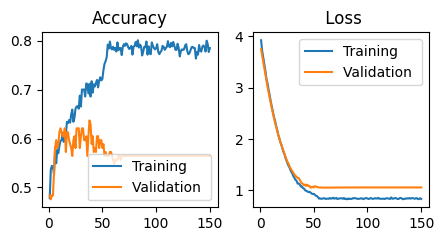

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


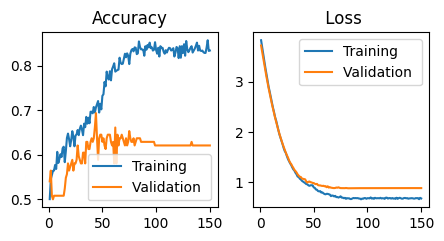

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 3ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


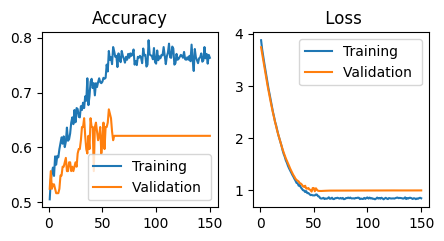

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


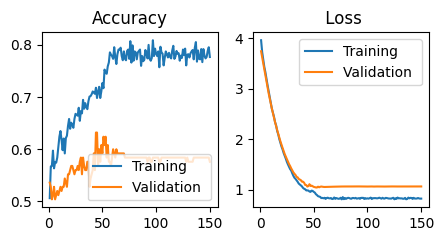

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


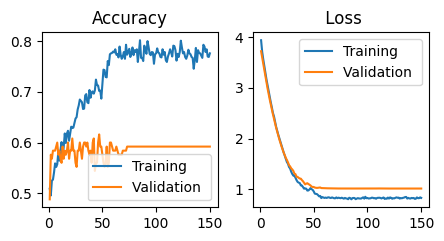

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


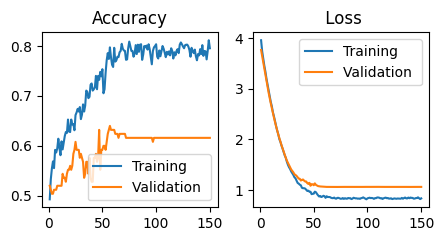

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 4ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


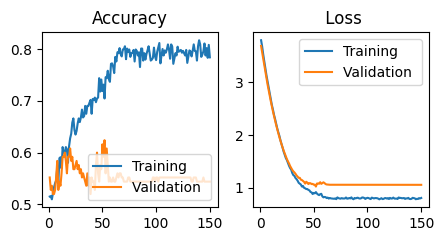

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


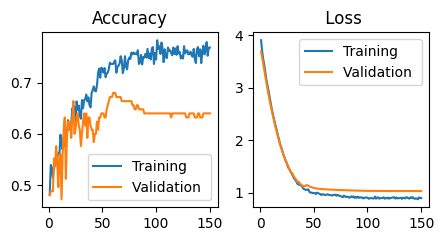

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


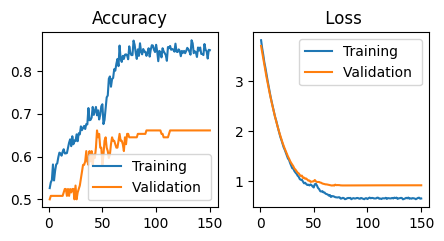

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


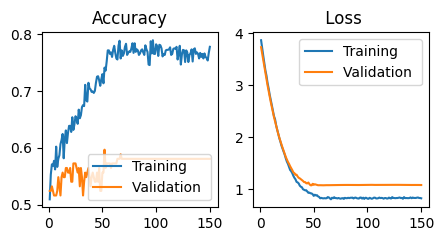

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


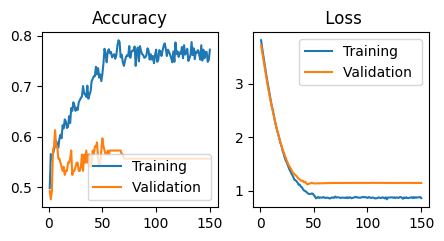

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


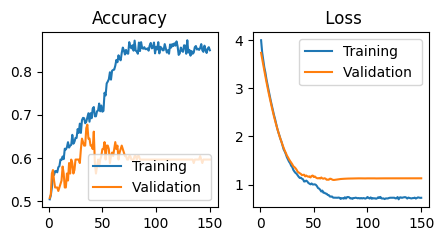

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


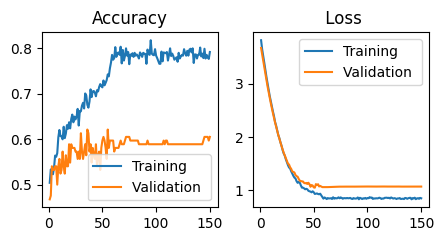

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


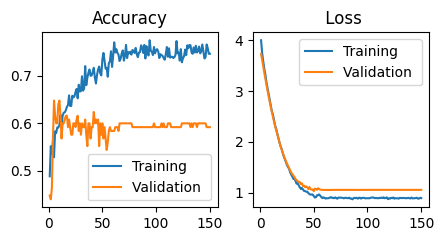

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


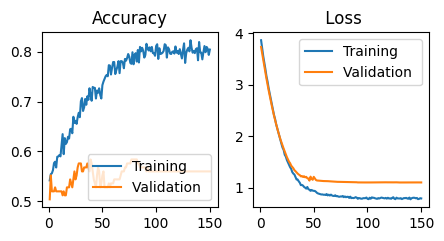

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


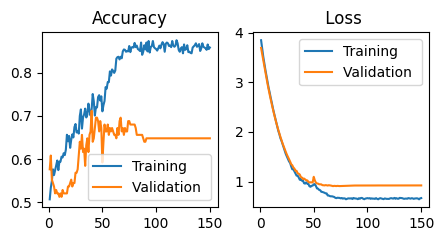

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


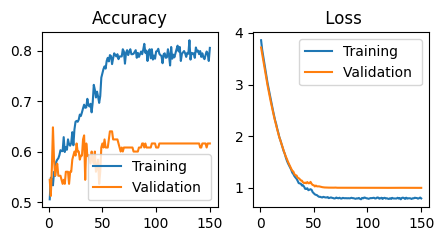

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


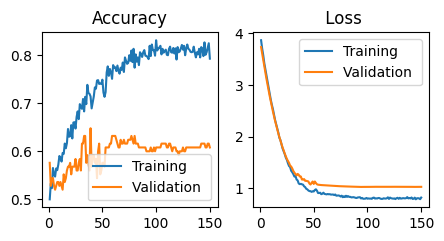

1120
125


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


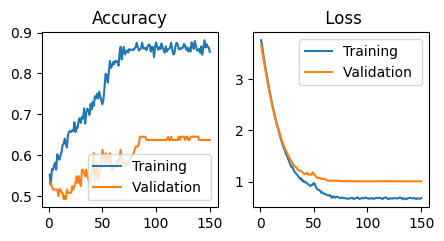

1121
124


/envs/ai4ni/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_548/2882847254.py:90: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(interp_fpr, fpr, tpr)


In [ ]:
AUC = []
acc = []
shap_values_per_cv = []
np.random.seed(1) # Reproducibility

n_cv = 10 #NUMERO DI KFOLD
for j in range(1):
  ii = 13
  print('#########', ii)
  cv_outer = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=ii) # Set random state
  #####plot roc curve####
  plt.figure()
  i = 0
  tprs = []
  aucs = []
  interp_fpr = np.linspace(0, 1, 100)

  for train_index, test_index in cv_outer.split(DF_1.iloc[:, 1:], DF_1.iloc[:, 0]):

      df_train, df_val = DF_1.iloc[train_index, :222], DF_1.iloc[test_index, :222]

      cv_inner = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=i) # Set random state

      for train_i, test_i in cv_inner.split(df_train.iloc[:,1:], df_train.iloc[:,0]):

        X_train, X_test = df_train.iloc[train_i, 1:], df_train.iloc[test_i, 1:]
        y_train, y_test = df_train.iloc[train_i, 0], df_train.iloc[test_i, 0]

        #load the model
        clear_session()
        model_strut = strutturale()

        # Compile the model
        model_strut.compile(optimizer=SGD(learning_rate = 0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
        #model_strut.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        #print(model_strut.summary())

        # Fit data to model
        history = model_strut.fit(X_train, y_train,
              batch_size=64,
              epochs=150,
              validation_data = (X_test, y_test),
              verbose=0,
              callbacks=[reduce_on_plateau])

        ###########################################################
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(1, len(acc)+1)
        #Train and validation accuracy
        plt.figure(figsize=(5, 5))
        plt.subplot(2, 2, 1)
        plt.plot(epochs_range, acc, label='Training ')
        plt.plot(epochs_range, val_acc, label='Validation ')
        plt.legend(loc='lower right')
        plt.title('Accuracy')
        #Train and validation loss
        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, loss, label='Training ')
        plt.plot(epochs_range, val_loss, label='Validation ')
        plt.legend(loc='upper right')
        plt.title(' Loss')
        plt.show()
        ###########################################################
        # prepare for SHAP
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        print(len(X_train)) ####-------
        print(len(X_test))

        # Use SHAP to explain predictions
        explainer = shap.GradientExplainer(model_strut, [X_train])
        shap_values = explainer.shap_values(X_test)

        #  SHAP information per fold per sample
        shap_values_per_cv.append(shap_values[0])
        ###########################################################
        _, val_acc = model_strut.evaluate(df_val.iloc[:, 1:], df_val.iloc[:, 0], verbose=0)
        acc.append(val_acc)

        #Compute Receiver operating characteristic (ROC)
        i=0
        preds = model_strut.predict(df_val.iloc[:, 1:], verbose=1)
        fpr, tpr, _ = roc_curve(df_val.iloc[:, 0], preds)
        roc_auc = auc(fpr, tpr)
        interp_tpr = interp(interp_fpr, fpr, tpr)
        tprs.append(interp_tpr)
        AUC.append(roc_auc)
        i += 1



In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(interp_fpr, mean_tpr)
std_auc = np.std(AUC)
plt.plot(interp_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Structural model',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [ ]:
print(len(AUC))
print(f'AUC: {np.mean(AUC)} (+- {np.std(AUC)})')
print(f'accuracy: {np.mean(acc)} (+- {np.std(acc)})')

SHAP on structural features

In [ ]:
# Establish lists to keep average Shap values
average_shap_values, stds, ranges = [],[],[]

for i in range(0, len(AUC)):
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i])
    df_per_obs = df_per_obs.abs()
    average_shap_values.append(df_per_obs.mean(axis=0).values)

fold = pd.DataFrame.from_dict(average_shap_values).T
#fold

In [ ]:
fold

In [ ]:
plot = fold.mean(axis=1).values
strutt = pd.DataFrame(plot, index = df_train.iloc[:, 1:].columns )
strutt['std']=fold.std(axis=1).values
strutt

In [ ]:
strutt = strutt.sort_values(by=0, ascending=False)
strutt

In [ ]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = strutt.iloc[:20,0].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value| (average of 10 repeats 5-fold)")

In [ ]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = strutt.iloc[:20].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value| (average of 10 repeats 5-fold)")

In [ ]:
controls = df_train[df_train.DX_GROUP==0]
ASD =  df_train[df_train.DX_GROUP==1]
list_f = strutt.iloc[:20].index.tolist()
for item in list_f:
    score =  Cohen(ASD, controls, item)
    print(item, score)

## Classificazione asd vs. td: solo features funzionali

In [ ]:
def funzionale():
  input_data= Input(5253,)
  x = Dense(64, 'relu', kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(input_data)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(32, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.1)(x)
  x = Dense(1, 'sigmoid', kernel_regularizer=l1(0.01))(x)
  x = tf.keras.Model(inputs=input_data, outputs=x)
  return x

In [ ]:
DF_1.iloc[:,0] # Grabs all rows and first 2 columns
DF_1.iloc[:,222:] # Grabs all rows and last 2 columns

DF_1 = pd.concat([DF_1.iloc[:,0],DF_1.iloc[:,222:]],axis=1) # Puts them together row wise
DF_1

In [ ]:
AUC = []
shap_values_per_cv = []
np.random.seed(1) # Reproducibility

n_cv = 10 #NUMERO DI KFOLD

for j in range(1):
  i=13
  cv_outer =StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=i) # Set random state
  #####plot roc curve####
  plt.figure()
  i = 0
  tprs = []
  aucs = []
  interp_fpr = np.linspace(0, 1, 100)

  for train_index, test_index in cv_outer.split(DF_1.iloc[:, 1:], DF_1.iloc[:, 0]):

      df_train, df_val = DF_1.iloc[train_index, :], DF_1.iloc[test_index, :]
      cv_inner = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=i) # Set random state

      # Loop through each fold and append the training & test indices to the empty lists above
      for train_i, test_i in cv_inner.split(df_train.iloc[:,:], df_train.iloc[:,0]):

        X_train, X_test = df_train.iloc[train_i, 1:], df_train.iloc[test_i, 1:]
        y_train, y_test = df_train.iloc[train_i, 0], df_train.iloc[test_i, 0]

        #load the model
        clear_session()
        model_strut = funzionale()

        # Compile the model
        model_strut.compile(optimizer=SGD(learning_rate = 0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

        # Fit data to model
        history = model_strut.fit(X_train, y_train,
              batch_size=64,
              epochs=150,
              validation_data = (X_test, y_test),
              verbose=0,
              callbacks=[reduce_on_plateau])


        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(1, len(acc)+1)
        #Train and validation accuracy
        plt.figure(figsize=(5, 5))
        plt.subplot(2, 2, 1)
        plt.plot(epochs_range, acc, label='Training ')
        plt.plot(epochs_range, val_acc, label='Validation ')
        plt.legend(loc='lower right')
        plt.title('Accuracy')
        #Train and validation loss
        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, loss, label='Training ')
        plt.plot(epochs_range, val_loss, label='Validation ')
        plt.legend(loc='upper right')
        plt.title(' Loss')
        plt.show()
        '''
        # prepare for SHAP
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()

        # Use SHAP to explain predictions
        explainer = shap.GradientExplainer(model_strut, [X_train])
        shap_values = explainer.shap_values(X_test)

        #  SHAP information per fold per sample
        shap_values_per_cv.append(shap_values[0])
        '''
        ###########################################################
        _, val_acc = model_strut.evaluate(df_val.iloc[:, 1:], df_val.iloc[:, 0], verbose=0)
        acc.append(val_acc)

        #Compute Receiver operating characteristic (ROC)
        i=0
        preds = model_strut.predict(df_val.iloc[:, 1:], verbose=1)
        fpr, tpr, _ = roc_curve(df_val.iloc[:, 0], preds)
        roc_auc = auc(fpr, tpr)
        interp_tpr = interp(interp_fpr, fpr, tpr)
        tprs.append(interp_tpr)
        AUC.append(roc_auc)
        i += 1

In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(interp_fpr, mean_tpr)
std_auc = np.std(AUC)
plt.plot(interp_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Functional model',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [ ]:
print(len(AUC))
print(f'AUC: {np.mean(AUC)} (+- {np.std(AUC)})')
print(f'accuracy: {np.mean(acc)} (+- {np.std(acc)})')

In [ ]:
# average Shap values
average_shap_values= []
for i in range(0, len(AUC)):
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i])
    df_per_obs = df_per_obs.abs()
    average_shap_values.append(df_per_obs.mean(axis=0).values)
fold = pd.DataFrame.from_dict(average_shap_values).T
fold

In [ ]:
plot = fold.mean(axis=1).values
func = pd.DataFrame(plot, index = df_train.iloc[:, 1:].columns )
func['std']=fold.std(axis=1).values
func = func.sort_values(by=0, ascending=False)
func

In [ ]:
sel = func[0:20].index.to_list()
sel = [eval(i) for i in sel]
df2.loc[sel]

In [ ]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = func.iloc[:20,0].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value|)")

In [ ]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = func.iloc[:20].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value|)")

In [ ]:
controls = df_train[df_train.DX_GROUP==0]
ASD =  df_train[df_train.DX_GROUP==1]
list_f = func.iloc[:20].index.tolist()
for item in list_f:
    score =  Cohen(ASD, controls, item)
    print(item, score)

# Joint model

In [ ]:
def model_sara():
    input_data= Input(221,)
    x = Dense(32,  'relu', kernel_initializer='normal', kernel_regularizer=l1(0.01))(input_data)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    x = tf.keras.Model(inputs=input_data, outputs=x)
    return x

def model_giaco():
    input_data= Input(5253,)
    x = Dense(64, 'relu', kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(input_data)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    x = tf.keras.Model(inputs=input_data, outputs=x)
    return x

In [ ]:
def merge_model(model_1, model_2):
    combined = Concatenate(axis=-1)([model_1.output, model_2.output])
    z = Dense(16, 'relu',  kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(combined)
    z = BatchNormalization()(z)
    z = Dropout(0.2)(z)
    z = Dense(8, 'relu',  kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(z)
    z = BatchNormalization()(z)
    z = Dropout(0.1)(z)
    z = Dense(1, 'sigmoid')(z) #, kernel_regularizer=l1(0.01))(z)
    model_def = Model(inputs=[model_1.input, model_2.input], outputs = z)
    return model_def

# Fit join model: nested 10-fold cv

ATTENZIONE riesegui la sezione import dataframe

In [ ]:
DF_1.head()  #il dataframe deve contenere sia le features strutturali che funzionali 

In [ ]:
AUC = []

shap_values_per_cv_s =[]
shap_values_per_cv_f =[]
var_f = []
var_s = []
np.random.seed(1) # Reproducibility
n_cv = 10 #NUMERO DI KFOLD


for j in range(1):
  i=13  #3
  print('--------------------------------',i,'-------------------------------------------')
  cv_outer =StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=i) # Set random state

  #####plot roc curve####
  plt.figure()
  i = 0
  tprs = []
  aucs = []
  interp_fpr = np.linspace(0, 1, 100)

  for train_index, test_index in cv_outer.split(DF_1.iloc[:, 1:], DF_1.iloc[:, 0]):
      df_train, df_val = DF_1.iloc[train_index, :], DF_1.iloc[test_index, :]

      cv_inner = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=i) # Set random state

      for train_i, test_i in cv_inner.split(df_train.iloc[:,:], df_train.iloc[:,0]):

        X_train, X_test = df_train.iloc[train_i, 1:222], df_train.iloc[test_i, 1:222]
        y_train, y_test = df_train.iloc[train_i, 0], df_train.iloc[test_i, 0]
        X_train2, X_test2 = df_train.iloc[train_i, 222:], df_train.iloc[test_i, 222:]

        #load the model
        clear_session()
        mod_1 = model_sara
        mod_2 = model_giaco
        modello = merge_model(mod_1(), mod_2())

        # Compile the model
        modello.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

        # Fit data to model
        history = modello.fit((X_train, X_train2), y_train,
                          batch_size=64,
                          epochs=150,
                          verbose=0,
                          validation_data = ((X_test, X_test2), y_test),
                          callbacks=[reduce_on_plateau]
                          )
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(1, len(acc)+1)
        #Train and validation accuracy
        plt.figure(figsize=(5, 5))
        plt.subplot(2, 2, 1)
        plt.plot(epochs_range, acc, label='Training ')
        plt.plot(epochs_range, val_acc, label='Validation ')
        plt.legend(loc='lower right')
        plt.title('Accuracy')
        #Train and validation loss
        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, loss, label='Training ')
        plt.plot(epochs_range, val_loss, label='Validation ')
        plt.legend(loc='upper right')
        plt.title(' Loss')
        plt.show()

        '''
        # prepare for SHAP
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        X_train2 = X_train2.to_numpy()
        X_test2 = X_test2.to_numpy()

        # Use SHAP to explain predictions
        explainer = shap.GradientExplainer(modello, [X_train, X_train2])
        shap_values = explainer.shap_values([X_test, X_test2])
        # nsamples maggario permettono un calcolo più accurato - rappresenta il numero di perturbazioni 200 def nsamples = 200

        #  SHAP information per fold per sample
        shap_values_per_cv_s.append(shap_values[0][0])
        shap_values_per_cv_f.append(shap_values[0][1])
        #var_s.append(var[0][0])
        #var_f.append(var[0][1])
        '''
        ###########################################################
        _, val_acc = modello.evaluate((df_val.iloc[:, 1:222], df_val.iloc[:, 222:]), df_val.iloc[:, 0], verbose=0)
        acc.append(val_acc)

        #Compute Receiver operating characteristic (ROC)
        i=0
        preds = modello.predict((df_val.iloc[:, 1:222], df_val.iloc[:, 222:]), verbose=1)
        fpr, tpr, _ = roc_curve(df_val.iloc[:, 0], preds)
        roc_auc = auc(fpr, tpr)
        interp_tpr = interp(interp_fpr, fpr, tpr)
        tprs.append(interp_tpr)
        AUC.append(roc_auc)
        i += 1
        print('---------------------AUC------------------', roc_auc)


In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(interp_fpr, mean_tpr)
std_auc = np.std(AUC)
plt.plot(interp_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Joint Fusion model',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [ ]:
# == Provide average scores ==
print(len(AUC))
print(f'AUC:{np.mean(AUC)} (+- {np.std(AUC)})')
print(f'accuracy: {np.mean(acc)} (+- {np.std(acc)})')

In [ ]:
# Establish lists to keep average Shap values
average_shap_values_s = []
average_shap_values_f = []

for i in range(0, len(AUC)):
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv_s[i])
    df_per_obs = df_per_obs.abs()
    average_shap_values_s.append(df_per_obs.mean(axis=0).values)

    df_per_f = pd.DataFrame.from_dict(shap_values_per_cv_f[i])
    df_per_f = df_per_f.abs()
    average_shap_values_f.append(df_per_f.mean(axis=0).values)

fold_s = pd.DataFrame.from_dict(average_shap_values_s).T
fold_f = pd.DataFrame.from_dict(average_shap_values_f).T

In [ ]:
'''fold_s.to_csv(path+'shap_value_joint_nested_strutturale_10kf.csv')
fold_f.to_csv(path+'shap_value_joint_nested_funzionale_10kf.csv')'''

# SHAP values Joint model: NORMALIZATION SHAP VALUES 

In [ ]:
fold_s = pd.read_csv(path+'shap_value_joint_nested_strutturale_10kf.csv')
fold_f = pd.read_csv(path+'shap_value_joint_nested_funzionale_10kf.csv')

In [ ]:
fold_s

In [ ]:
fold_s = fold_s.iloc[:,1:]
fold_f = fold_f.iloc[:,1:]

In [ ]:
s = 221/(2*(221 + 5253))
f = 5253/(2*(221 + 5253))

In [ ]:
# NORMNALIZZAZIONE STRUTTURALE
fold_s_n = (fold_s/fold_s.sum(axis=0))*s*100
plot = fold_s_n.mean(axis=1).values
strutt = pd.DataFrame(plot, index = DF_1.iloc[:, 1:222].columns )
strutt['std']=fold_s_n.std(axis=1).values
strutt = strutt.sort_values(by=0, ascending=False)
strutt

In [ ]:
# NORMNALIZZAZIONE FUNZIONALE
norm = fold_f.sum(axis=0)
fold_f_n = (fold_f/fold_f.sum(axis=0))*f*100
plot_f = fold_f_n.mean(axis=1).values
func = pd.DataFrame(plot_f, index = DF_1.iloc[:, 222:].columns )
func['std']=fold_f_n.std(axis=1).values
func = func.sort_values(by=0, ascending=False)
'''func = func.iloc[:35, :]
func.to_excel(path+'risultati_funzionali.xlsx')'''
func


In [ ]:
func =pd.read_excel(path+'risultati_funzionali.xlsx')
func['name'] = func['r1'].astype(str) + ' - ' + func['r2'].astype(str)

del func['r1']
del func['r2']
del func['Unnamed: 0']
func = func.set_index('name')

In [ ]:
func

In [ ]:
all_m_s =  pd.concat([strutt,func])
all_m_s = all_m_s.sort_values(by=0, ascending=False)
all_m_s

In [ ]:
th99 = all_m_s.iloc[:, 0].quantile(0.995)
th99

In [ ]:
#all_m_s.to_csv(path+'shap_value_joint_nested.csv')

# 99-95 esimo percentile

In [ ]:
all_m_s[all_m_s[0] >= th99][0]

In [ ]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = all_m_s[all_m_s[0] >= th99][0].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value|)")

# Choen'd effect size

In [ ]:
controls = DF_1[DF_1.DX_GROUP==0]
ASD =  DF_1[DF_1.DX_GROUP==1]
list_f = all_m_s.iloc[:].index.tolist()
score_df = []
for item in list_f:
    score =  Cohen(ASD, controls, item)
    score_df.append(score)
    #print(item, score)
all_m_s['choen']=score_df

In [ ]:
all_m_s

# Find region's coord in HO

In [ ]:
!pip install nilearn

In [ ]:
perc_95 = dict_f['Unnamed: 0'][0:25]
perc_95

In [ ]:
lista_con = df2.loc[perc_95]
lista_con

In [ ]:
all_m_s.iloc[:28, :]

In [ ]:
'''#features ASD>TD
lista_conn = lista_con.drop(731)
lista_conn = lista_conn.drop(3254)
lista_conn = lista_conn.drop(3295)

lista_conn = lista_conn.drop(3004)
lista_conn = lista_conn.drop(1737)
lista_conn = lista_conn.drop(4545)
lista_conn = lista_conn.drop(4935)
lista_conn = lista_conn.drop(1455)
lista_conn = lista_conn.drop(395)'''


#features ASD>TD
lista_conn = lista_con.loc[[731, 3254, 3295, 3004, 1737, 4545, 4935, 1455, 395]]

In [ ]:
lista_conn

In [ ]:
l1 = lista_conn['r1'].to_list()
l2 = lista_conn['r2'].to_list()

In [ ]:
l = l1 + l2

In [ ]:
sam_list = list(set(l))
sam_list

In [ ]:
len(sam_list)

In [ ]:
region_c = []
label_c = []

In [ ]:
from nilearn import datasets
from nilearn import plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image
#load HO atlas
atlas_ho = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')  #sub-maxprob-thr50-2mm - cortl-maxprob-thr25-2mm
atlas_file = atlas_ho.maps

# Load labels for each atlas region
labels = atlas_ho.labels[1:]
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_file)
print(len(labels))


In [ ]:
atlas_ho = datasets.fetch_atlas_harvard_oxford('cortl-maxprob-thr25-2mm')
atlas_file = atlas_ho.maps
# Load labels for each atlas region
labels = atlas_ho.labels[1:]
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_file)
print(len(labels))


In [ ]:
for i, e in enumerate(labels):
  for j, n in enumerate(sam_list):
    if e == n:
      region_c.append(coordinates[i])
      label_c.append(e)

In [ ]:
len(label_c)

# PLOT connectoma


In [ ]:
lista_conn

In [ ]:
for i in range(0, len(label_c)):
  print(i, region_c[i],label_c[i])

In [ ]:
index_1 = []
for j, n in enumerate(l1):
  for i, e in enumerate(label_c):
    if n == e:
     index_1.append(i)

In [ ]:
index_2=[]
for j, n in enumerate(l2):
  for i, e in enumerate(label_c):
    if n == e:
     index_2.append(i)

In [ ]:
lista_conn['i1'] = index_1
lista_conn['i2'] = index_2
lista_conn

In [ ]:
mat =np.zeros((len(region_c), len(region_c)))

for index, (value1, value2) in enumerate(zip(index_1, index_2)):
    #print(index, value1 , value2)
    mat[value1][value2] = 1
mat

In [ ]:
mat = mat + mat.T
coordinates = np.array(region_c)  # 3D coordinates of parcels

In [ ]:
from matplotlib import cm
from matplotlib import pyplot as plt

color_dict = {}
cmap = cm.get_cmap('tab20', len(label_c))

for rsn, c in zip(label_c, cmap.colors.tolist()):
    color_dict[rsn] = tuple(c)



node_color = []
for nw in label_c:
    node_color.append(color_dict[nw])

coords = coordinates

N = len(coords)

plotting.plot_connectome(mat,
                         coords,
                         title='ASD>TD',
                         node_color=node_color,
                          display_mode="lyrz",
                         edge_kwargs = {"linewidth":1.7, "color": 'red'})


In [ ]:
from matplotlib.lines import Line2D

legend_elements = []
for k,v in color_dict.items():
    legend_elements.append(Line2D([0], [0], marker='o', color=v, label=k,
                          markerfacecolor=v, markersize=5))
# Create the figure
fig, ax = plt.subplots()
ax.axis("off")
ax.legend(handles=legend_elements, loc='center')